## CPU vs GPGPU

In [41]:
from common import get_device
print(device := get_device())

mps


In [42]:
import torch
import time

# 行列サイズ
M, K, N = 4096, 4096, 4096

# CPU用のランダム行列
A_cpu = torch.randn(M, K)
B_cpu = torch.randn(K, N)

# GPU用のランダム行列（もしGPUなければCPUで計測）
A_gpu = A_cpu.to(device)
B_gpu = B_cpu.to(device)

# CPUで計測
start_cpu = time.time()
_ = torch.matmul(A_cpu, B_cpu)
end_cpu = time.time()

# GPUで計測
if torch.cuda.is_available():
    torch.cuda.synchronize()  # GPU計測前に同期
start_gpu = time.time()
_ = torch.matmul(A_gpu, B_gpu)
if torch.cuda.is_available():
    torch.cuda.synchronize()  # GPU計測後に同期
end_gpu = time.time()

max_len = max(len(str(A.device)) for A in [A_cpu, A_gpu])
print(f"{str(A_cpu.device):<{max_len}}: {end_cpu - start_cpu:.3e} 秒")
print(f"{str(A_gpu.device):<{max_len}}: {end_gpu - start_gpu:.3e} 秒")

cpu  : 1.027e-01 秒
mps:0: 1.085e-03 秒


## Classification

画像データ: mps:0, モデル: mps:0


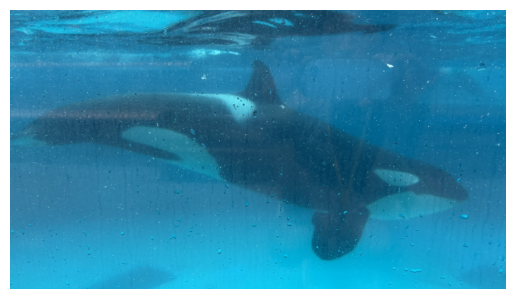

killer whale      : 0.5811
sea lion          : 0.3126
great white shark : 0.0299
hammerhead        : 0.0162
dugong            : 0.0160

> この画像はシャチです！


In [43]:
import torch
from torchvision import models, transforms
from PIL import Image

# 画像ファイルパス
image_path = "data/IMG_0062.jpeg"

# デバイス設定（GPUがあればGPUを使用）
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 事前学習済みのResNet18をロード
weights = models.ResNet18_Weights.DEFAULT   # 最も推奨される事前学習済み重みを使う指定
model = models.resnet18(weights=weights)
model.eval()  # 推論モードに設定
model = model.to(device)

# ImageNetのラベルマップを取得（シャチがあるか確認）
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = [line.strip() for line in urllib.request.urlopen(url)]

# 画像の前処理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# 画像を読み込み前処理
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0).to(device)  # バッチ次元追加

# 推論
with torch.no_grad():
    print(f'画像データ: {input_tensor.device}, モデル: {next(model.parameters()).device}')
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# 画像を表示
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # 軸を非表示にする
plt.show()

# 上位5件の予測結果を表示
top5_prob, top5_catid = torch.topk(probabilities, 5)
top5_labels = [str(imagenet_classes[top5_catid[i]], 'utf-8') for i in range(top5_prob.size(0))] # バイト列を文字列に変換して判定
max_len = max(len(label) for label in top5_labels)
for i in range(top5_prob.size(0)):
    print(f"{top5_labels[i]:<{max_len+1}}: {top5_prob[i].item():.4f}")

# シャチかどうかを簡単に判定
if "killer whale" in top5_labels:
    print("\n> この画像はシャチです！")
else:
    print("\n> この画像にシャチはいません。")